<a href="https://colab.research.google.com/github/wkdtjrrb/SPIDER/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%8A%A4%ED%84%B0%EB%94%94_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#합성곱 신경망을 사용한 이미지 분류

* 데이터 스케일을 [0,225] 에서 [0,1] 사이로 바꾸고 훈련세트와 검증세트로 나눔

* 완전 연결 신경망은 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼침

* 합성곱 신경망은 2차원 이미지를 그대로 사용 > reshape()로 배열 차원 그대로 유지

* 흑백 이미지는 채널 차원이 없는 2차원이므로 마지막에 채널 차원을 추가해야 함

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

#(48000,28,28) 크기의 인풋이 (48000,28,28,1)인 train_scale이 됨
# 3차원 배열이 4차원 배열로 변함
train_scaled = train_input.reshape(-1,28,28,1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled,train_target,test_size = 0.2, random_state = 42)

**합성곱 신경망 만들기**

In [ ]:
# add()메서드로 층을 하나씩 차례대로 추가하기
model = keras.Sequential()

# 첫번째 합성곱 - 풀링 층 추가
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2))

# 두번째 합성곱 - 풀링층 추가
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

# flatten - dense 은닉층 - dense 출력층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4)) # 드롭아웃 적용
model.add(keras.layers.Dense(10, activation='softmax')) # 분류문제 > softmax

In [ ]:
#최종 특성맵의 크기 (7,7,64)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

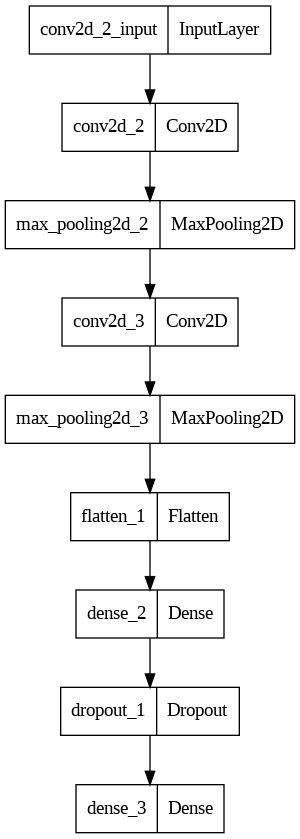

In [ ]:
# 층의 구성을 그림으로 표현
keras.utils.plot_model(model)

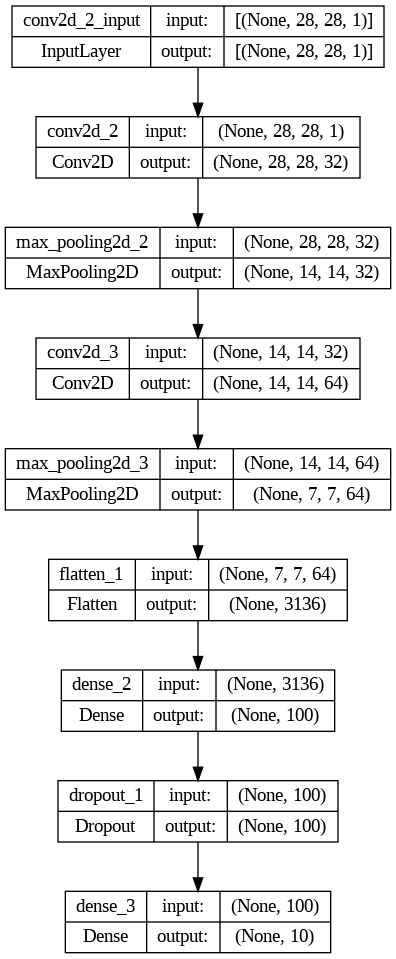

In [ ]:
# show_shape로 입력과 출력의 크기 표현
keras.utils.plot_model(model, show_shapes=True)

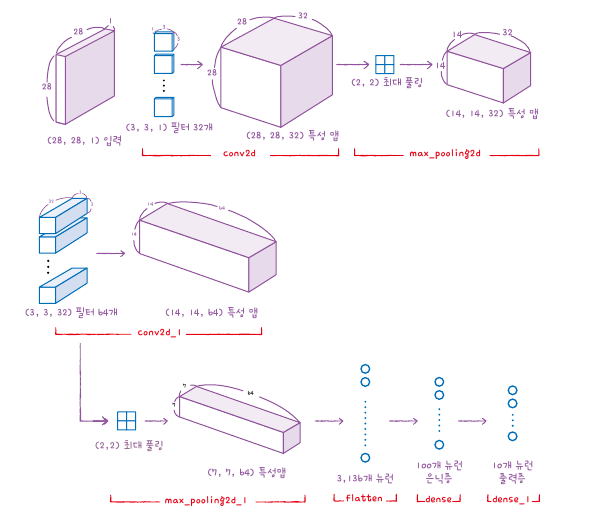

**모델 컴파일과 훈련**

ADAM 옵티마이저

MODELCHECKPOINT 콜백

EARLY STOPPING

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 88s 58ms/step - loss: 0.5199 - accuracy: 0.8138 - val_loss: 0.3340 - val_accuracy: 0.8785
Epoch 2/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.3474 - accuracy: 0.8758 - val_loss: 0.2815 - val_accuracy: 0.8953
Epoch 3/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.2963 - accuracy: 0.8936 - val_loss: 0.2667 - val_accuracy: 0.9011
Epoch 4/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2614 - accuracy: 0.9053 - val_loss: 0.2380 - val_accuracy: 0.9104
Epoch 5/20
1500/1500 [==============================] - 76s 51ms/step - loss: 0.2388 - accuracy: 0.9125 - val_loss: 0.2359 - val_accuracy: 0.9107
Epoch 6/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.2190 - accuracy: 0.9181 - val_loss: 0.2205 - val_accuracy: 0.9200
Epoch 7/20
1500/1500 [==============================] - 76s 51ms/step - loss: 0.2040 - accuracy: 0.9250 - val_loss: 0.2166 -

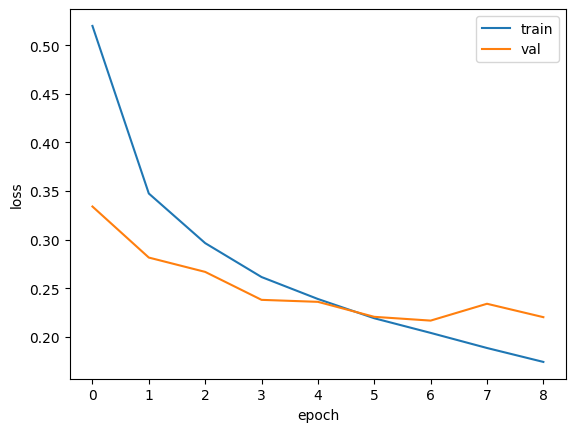

In [ ]:
# 손실 그래프를 그려 조기종료가 잘 이루어졌는지 확인
# 일곱 번째 에포크가 최적

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# validate set에 대한 성능 평가
# 일곱 번째 에포크와 같은 출력 > early stopping 콜백이 잘 복원했음
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 5s 13ms/step - loss: 0.2166 - accuracy: 0.9193


[0.21659539639949799, 0.9193333387374878]

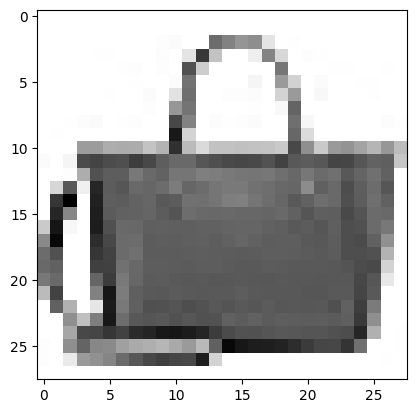

In [ ]:
# 첫 번째 샘플 이미지
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [ ]:
# 모델은 이미지를 어떻게 예측하는지 확인
# 9번째 값이 1이고 나머지는 0에 가까움 = 아홉 번째 클래스로 예측함
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 25ms/step
[[6.8526592e-15 2.8065380e-23 3.1602085e-16 5.8371522e-17 1.9621209e-16
  2.0310519e-14 9.7819702e-14 2.2273300e-16 1.0000000e+00 7.6629678e-16]]


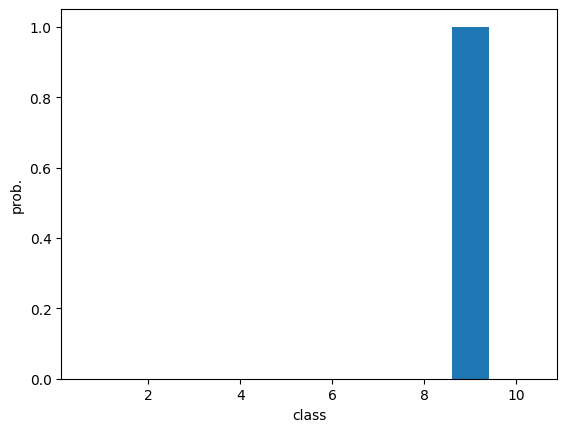

In [ ]:
# 예측 그래프
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
# 리스트에 레이블 저장
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
# 예측 결과
import numpy as np
print(classes[np.argmax(preds)])

가방


In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
# 모델 성능 평가
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 13ms/step - loss: 0.2434 - accuracy: 0.9116


[0.24339023232460022, 0.9115999937057495]

# 합성곱 신경망의 시각화

**가중치 시각화**

필터 = 가중치(커널) + 절편

입력과 커널이 같은 패턴의 값을 가지면
특성맵에서의 높은 출력값이 나오고

다른 패턴의 값이 있으면 낮은 출력값이 나온다.

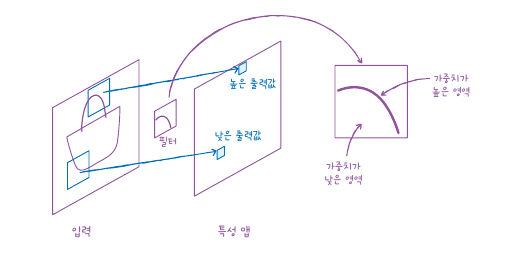

In [ ]:
model = keras.models.load_model('best-cnn-model.h5')

In [ ]:
# keras 모델에 추가한 층이 layers 속성에 파이썬 리스트 형태로 저장
model.layers

In [ ]:
# 첫 번째 합성곱 층의 가중치, 절편의 크기
# 커널의 크기는 (3,3) > 입력 깊이 추가 (3,3,1) > 필터 개수 추가 (3,3,1,32)
# 절편은 필터마다 1개씩 할당 (32,)

conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
# 가중치 배열의 평균과 표준편차
# 평균은 0에 가깝고 표준편차는 0.25

conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.028726365 0.2539489


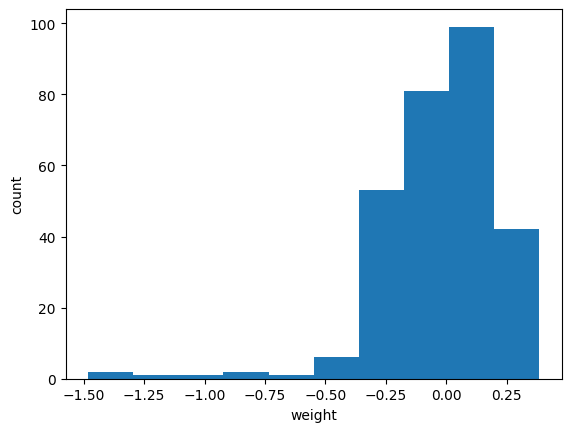

In [ ]:
# 가중치의 분포를 히스토그램으로 확인
# 0을 중심으로 종모양

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

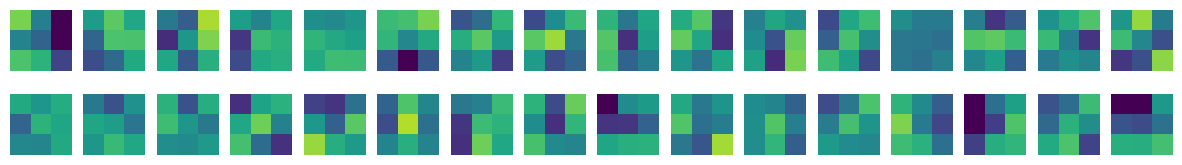

In [ ]:
# 32개의 커널 출력
# 가중치마다 패턴이 있음(밝은 부분이 높은 가중치(해당 커널 내에서 상대적인 크기를 나타냄))

fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

In [ ]:
# 훈련하지 않은 빈 합성곱 신경망

no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

In [ ]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
#가중치의 평균은 이전(학습했던)의 것과 비슷하게 0과 가까움
#그러나 표준편차가 0.08로 이전의 0.25에 비해 매우 작음

no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.002369949 0.08150018


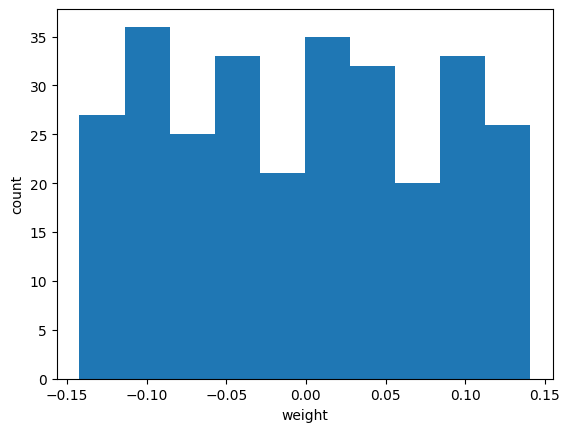

In [ ]:
# 비교적 고른 분포의 가중치
# 텐서플로가 신경망의 가중치를 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

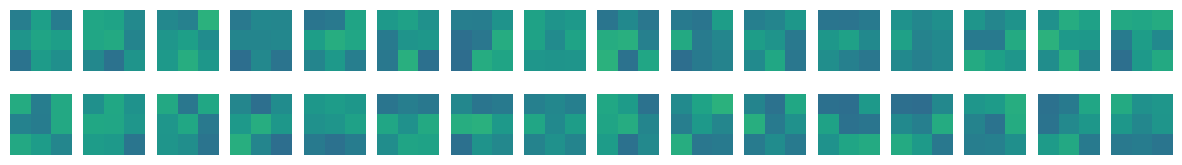

In [ ]:
# weight 색이 이전에 비해 밋밋함 = weight가 균등
# 이전의 신경망 = weight 색이 다양함 = 합성곱 신경망이 분류 정확도를 높이기 위해
# 유용한 패턴을 학습했기 때문

fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

**함수형 API**

* sequential 클래스는 층을 차례대로 쌓은 모델

* 복잡한 딥러닝 모델(입력이 2개 이상이거나 출력이 2개이상)에서는 sequential을 사용하기 어렵다

* 함수형 API로 구현



In [ ]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_2_input'), name='conv2d_2_input', description="created by layer 'conv2d_2_input'")


In [ ]:
# model.input과 model.layers[0].output을 연결하는 모델
# 첫 번째 합성곱 층이 만든 특성맵 확인

conv_acti = keras.Model(model.input, model.layers[0].output)

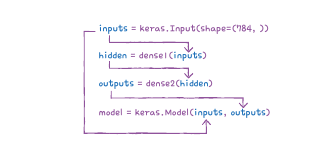

model 객체의 순서

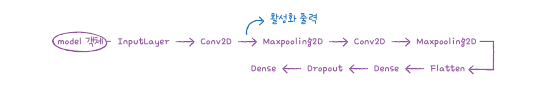

첫 번째 Conv2D의 출력이 필요
> model 객체의 입력과 Conv2D의 출력을 연결한 새로운 모델 생성

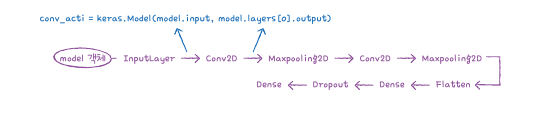

**특성 맵 시각화**

In [ ]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

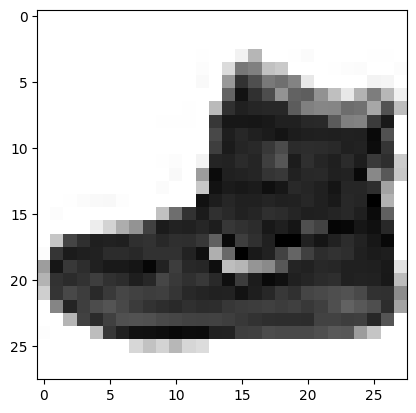

In [ ]:
# 훈련 세트 첫 번째 샘플 확인

plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [ ]:
# 위의 샘플을 conv_acti 모델에 주입

inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0
feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 0s 75ms/step


In [ ]:
print(feature_maps.shape)

(1, 28, 28, 32)


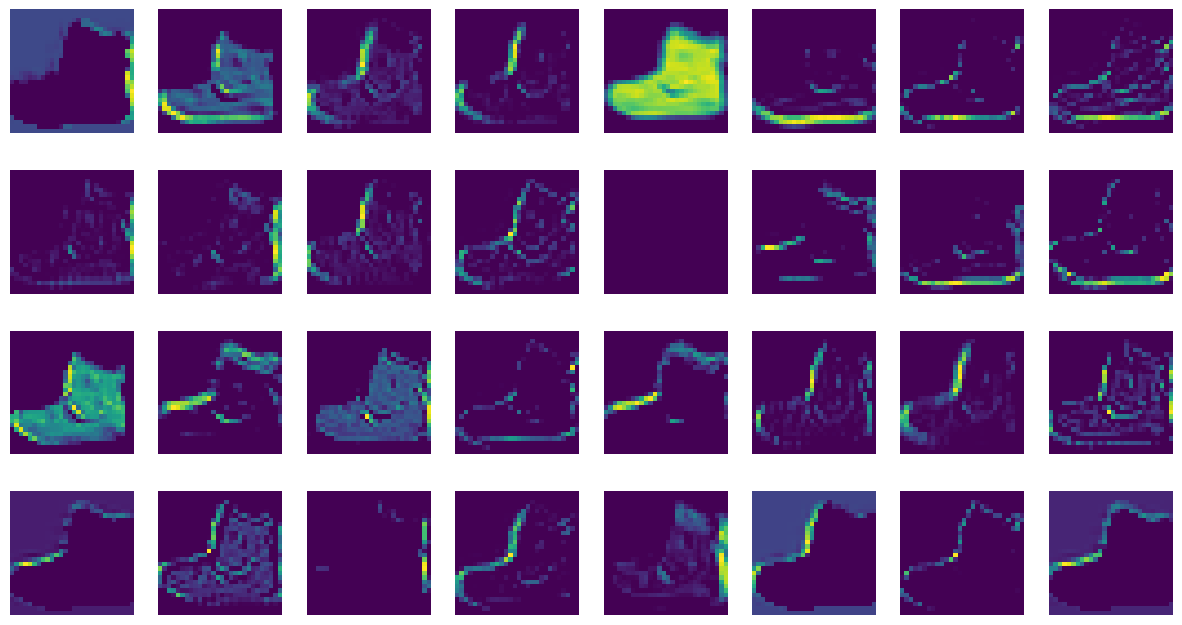

In [ ]:
# 학습한 모델에 주입한 결과(특성 맵) 확인

fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')
plt.show()

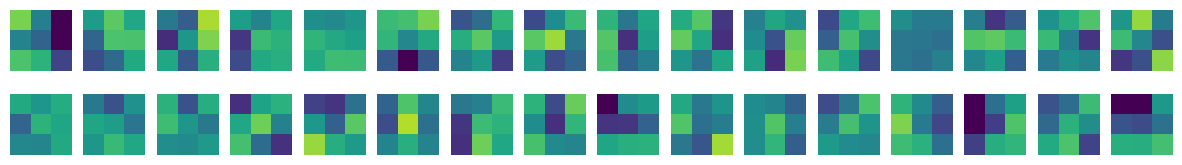

사용한 필터(하단)과 그 결과(상단)

1. 첫 번째 필터는 왼쪽 수직선을 가진 패턴에 강하게 반응

2. 다섯 번째 필터는 전면이 모두 칠해진 패턴에 강하게 반응

In [ ]:
# 두 번째 합성곱 층이 만든 특성 맵 확인
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [ ]:
inputs = train_input[0:1].reshape(-1,28,28,1)/255.0
feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 133ms/step


In [ ]:
# 첫 번째 풀링층에서 가로세로 크기가 절반으로 줄어듦
# 두 번째 합성곱 층의 필터 개수는 64개

print(feature_maps.shape)

(1, 14, 14, 64)


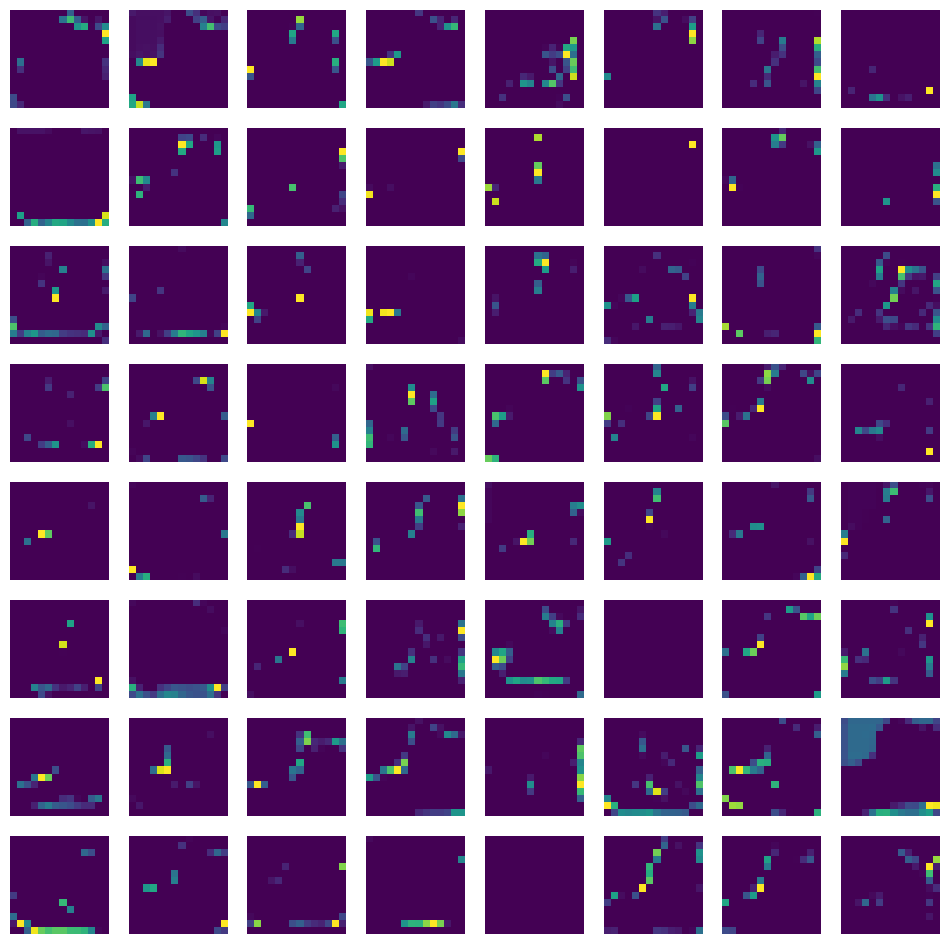

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')
plt.show()

- 위의 특성 맵은 시각적으로 이해가 어려움

- 두 번째 합성곱 층의 첫 번째 필터가 앞서 출력한 32개의 특성 맵과 곱해져 두 번째 합성곱 층의 첫번째 특성 맵이 된다.

- 이렇게 계산된 출력은 (14,14,32) 특성 맵에서 어떤 부위를 감지하는지 직관적으로 이해하기 어렵다

- 해당 현상은 합성곱 층을 많이 쌓을수록 심해진다.

- 즉 첫 번째 합성곱 층은 이미지의 시각적인 정보(커널의 패턴과 같은 패턴이 어디에 나타나는지)를 감지하고 이후의 합성곱 층은 앞서 발견한 시각적인 정보를 바탕으로 추상적인 정보(고급 패턴이나 사물의 일반적인 형태)를 학습한다.

- 이러한 원리로 마지막에 완전 연결층(FC layer)이 추가되어 클래스에 대한 확률 분포를 생성

**낮은 수준의 특성과 높은 수준의 특성**

* 낮은 수준의 특성(low-level-features)

> 선, 모서리, 색상 변화등의 간단한 변화

* 높은 수준의 특성(high-level-features)

> 낮은 수준의 특성을 조합해 만든 복잡한 시각적 특성

> 얼굴의 특정 부분이나 동물의 특정 형태가 여기에 포함

# 문제

이전 예제에서 만든 본인의 모델을 활용하여 다른 이미지에 대한 예측을 해보고 결과를 확인해보자

4422102/4422102 [==============================] - 0s 0us/step


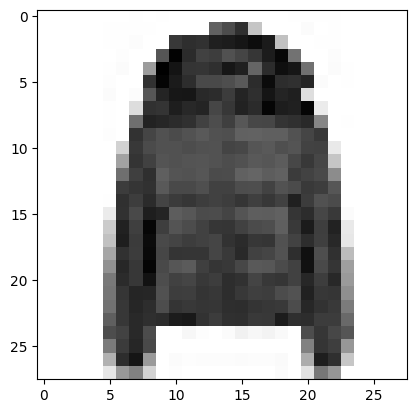

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1,28,28,1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled,train_target,test_size = 0.2, random_state = 42)
plt.imshow(val_scaled[3].reshape(28, 28), cmap='gray_r')
plt.show()

In [ ]:
my_model = keras.Sequential()

my_model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', strides=1, input_shape=(28,28,1))) # 합성곱 층
my_model.add(keras.layers.MaxPooling2D(2))

my_model.add(keras.layers.Flatten())
my_model.add(keras.layers.Dropout(0.3))
my_model.add(keras.layers.Dense(512, activation='relu'))
my_model.add(keras.layers.Dropout(0.3))
my_model.add(keras.layers.Dense(128, activation='relu'))
my_model.add(keras.layers.Dropout(0.3))
my_model.add(keras.layers.Dense(10, activation='softmax'))

my_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True, verbose=1)
reducelr_cb = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, verbose=1)

my_model.fit(train_scaled, train_target, epochs=50, verbose=1,
          validation_data=(val_scaled, val_target),
          batch_size=128,
          callbacks=[checkpoint_cb, reducelr_cb, early_stopping_cb])

my_model = keras.models.load_model('best-model.h5')
my_model.evaluate(val_scaled, val_target)

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.8099
Epoch 1: val_loss improved from inf to 0.32419, saving model to best-model.h5
375/375 [==============================] - 83s 217ms/step - loss: 0.5296 - accuracy: 0.8099 - val_loss: 0.3242 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8802
Epoch 2: val_loss improved from 0.32419 to 0.28979, saving model to best-model.h5
375/375 [==============================] - 77s 205ms/step - loss: 0.3339 - accuracy: 0.8802 - val_loss: 0.2898 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8958
Epoch 3: val_loss improved from 0.28979 to 0.26466, saving model to best-model.h5
375/375 [==============================] - 75s 199ms/step - loss: 0.2873 - accuracy: 0.8958 - val_loss: 0.2647 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 4/50
375/375 [=========

[0.2249400019645691, 0.9153333306312561]

In [ ]:
preds = my_model.predict(val_scaled[3:4])
print(preds)

1/1 [==============================] - 0s 56ms/step
[[1.5739523e-03 5.5120216e-04 7.9286985e-02 3.5950779e-03 8.7759763e-01
  1.9097248e-05 3.6860067e-02 1.9350189e-05 4.4696112e-04 4.9651502e-05]]


In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

import numpy as np
print(classes[np.argmax(preds)])

코트
